# **Challenge Overview – CRM Document Extraction**

Your mission is to design an end-to-end intelligence platform that extracts unstructured data, standardizes it, and creates a powerful graph database that integrates a crm platform to optimize companies interactions with clients. Going beyond simple data processing, you'll enhance this network by integrating real-time community event data to create a dynamic recommendation engine that can identify relevant upcoming events for specific community segments, or other relevant information that can reference or be of use to specific clients based on the information on the database.
<br>
<br>

### **Tech & Tools**

It is mandatory to develop the solution in **Google Colab** using **Python**.

Other than that, you are completely free to choose your own:

•	Libraries and packages: Use any tool you need (e.g., Pandas, Scikit-learn, LangChain, etc.)

•	Visualization tools: Python-based tools (Matplotlib, Seaborn), Power BI, Tableau, etc. (if you use external visualization tools, don't forget to include prints in the submission zip folder)

•	AI assistants: Feel free to consult ChatGPT, GitHub Copilot, Gemini, or any other.


<br>
<br>

### **Tech Configuration**

To visualize the relationships between laws, the dev team suggests you to use the Graph Database Neo4j. Follow the nexts steps to set up it:

**1** - Go to: https://neo4j.com/sandbox/

**2** - Click "Launch the free SandBox"

**3** - Make an account

**4** - Select "Blank Sandbox"

**5** - Open "Blank Sandbox Sandbox Credentials.txt" to get the credentials to your sandbox and input them in the 4th notebook cell


To extract real-time information about upcoming events in Portugal, you can use this api:

**1** - Go to https://serpapi.com/

**2** - In the upper right corner, click on "Register".
Fill in the necessary information to create the account

**3** - Verify the email and phone number used during registration

**4** - Select the "Free Plan" option to start for free

**5** - Go to the upper left corner, below "Your Account".
Click on "API Key" or go directly to https://serpapi.com/manage-api-key

**6** - Replace the API Key in the code as needed

<br>
<br>

### **Data**

**1** - If using Google Colab, we recommend you upload all the data to a folder on the same directory of this notebook, like on the picture bellow:

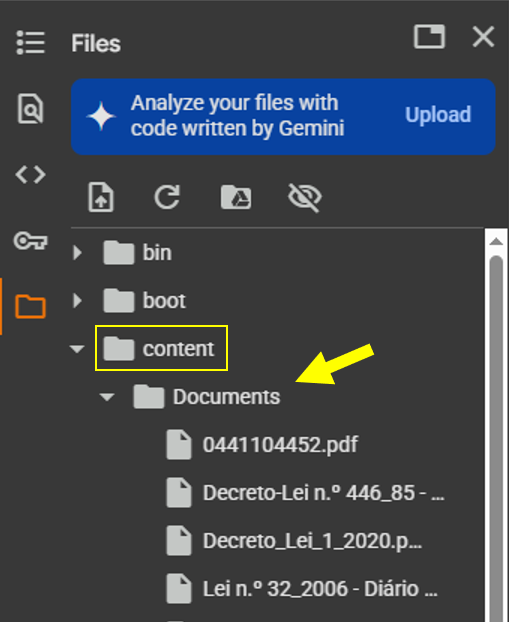

### **Tips**

•	We suggest using either Gemini or LLaMA as your LLM. Consider your solution’s priorities: Gemini is faster but has context limitations, while LLaMA can handle more context but may be slower. Feel free to use, adapt and complement the functions as needed, or redo them completely to your specifications.

•	You can visualize your graph in different tools. Neo4j offers different options to view and query data online, in the browser.

•	You can show the usefulness of your new tool by showing interesting queries and visualizations.

In [ ]:
!pip install fitz==0.0.1.dev2 tools==1.0.2 neo4j==5.28.1 -q

In [ ]:
#Install Tesseract and required libraries
!apt-get install tesseract-ocr
!pip install pytesseract Pillow

In [ ]:
%pip install yfiles_jupyter_graphs==1.10.5 --quiet

In [ ]:
!pip install langchain-google-genai -q

In [ ]:
pip install -r requirements.txt

In [ ]:
!unzip -q Data.zip

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from serpapi import GoogleSearch

import fitz
import re
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import requests

from google import genai
from google.genai import types

from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
import os

try:
  import google.colab
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  pass

In [ ]:
!pip install serpapi -q

In [ ]:
NEO4J_URI="*"
NEO4J_USERNAME="*"
NEO4J_PASSWORD="*"
NEO4J_DATABASE="*"

In [94]:
def config_llm_gemini(api_key: str, temperature: int, ocr_text: str) -> str:
  '''LLM api calling using Gemini  '''
  os.environ["GOOGLE_API_KEY"] = api_key

  llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=temperature)

  prompt = (
        "You are an assistant that receives poorly extracted text from OCR. "
        "Your job is to clean up formatting issues, fix spelling errors, and produce a readable and corrected version. "
        "Here is the raw text:\n\n"
        f"{ocr_text}\n\n"
        "Please return the improved version below."
  )

  response = llm([HumanMessage(content=prompt)])
  return response.content

In [95]:
def enhance_image(image):
    image = image.convert("L")
    image = unsharp_mask(image)

    image = image.filter(ImageFilter.SHARPEN)
    contrast = ImageEnhance.Contrast(image)
    brightness = ImageEnhance.Brightness(image)
    image = contrast.enhance(1.2)
    image = brightness.enhance(1)

    # Aplicar threshold para binarizar
    #image = image.point(lambda x: 0 if x < 140 else 255, '1')
    return image

In [96]:
import cv2
import numpy as np

def unsharp_mask(image: Image.Image, amount=1.5, radius=1, threshold=0):
    img = np.array(image)
    blurred = cv2.GaussianBlur(img, (0, 0), radius)
    sharp = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return Image.fromarray(np.clip(sharp, 0, 255).astype(np.uint8))

In [97]:
def show_image(image):
    image.show()

In [ ]:
pip install python-doctr[torch]

In [52]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

In [ ]:
api_key = "*"
# Function to extract text from image
def extract_text_from_image(image_path):

  image = Image.open(image_path)
  image_enhance = enhance_image(image)
  extracted_text = pytesseract.image_to_string(image_enhance)
  improved_text = config_llm_gemini(api_key, temperature=1.0, ocr_text=extracted_text)

  return improved_text

In [ ]:
ocr_text = extract_text_from_image("0aca1956-0245-4709-a5d3-8b9f25bcbb5f.jpeg")
print(ocr_text)

In [ ]:
folder_path = "Data"
def list_images_in_folder(folder_path, extension=".jpeg"):
    """Lista todas as imagens em uma pasta com a extensão especificada."""
    return [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(extension)
        ]

In [100]:
def process_images(folder_path):
    image_paths = list_images_in_folder(folder_path)
    #print(image_paths)
    enhanced_images = []
    for path in image_paths:
        print(path)
        print(extract_text_from_image(path))
        text = extract_text_from_image(path)
        enhanced_images.append(text)
    return enhanced_images

In [ ]:
citizens_texts = process_images(folder_path)

In [139]:
def parse_citizen_data(text):
    """Extrai os campos do texto OCR em um dicionário estruturado."""
    data = {}
    # Use .group(1).strip() if a match is found, otherwise use an empty string
    data['Nome'] = (re.search(r'Nome[:\-]?\s*(.*)', text).group(1).strip()
                    if re.search(r'Nome[:\-]?\s*(.*)', text) else "")
    data['Estado Civil'] = (re.search(r'Estado Civil[:\-]?\s*(.*)', text).group(1).strip()
                          if re.search(r'Estado Civil[:\-]?\s*(.*)', text) else "")
    data['Escolaridade'] = (re.search(r'Escolaridade[:\-]?\s*(.*)', text).group(1).strip()
                          if re.search(r'Escolaridade[:\-]?\s*(.*)', text) else "")
    data['E-mail'] = (re.search(r'E[- ]?mail[:\-]?\s*([\w\.-]+@[\w\.-]+)', text).group(1).strip()
                      if re.search(r'E[- ]?mail[:\-]?\s*([\w\.-]+@[\w\.-]+)', text) else "")
    data['Rua'] = (re.search(r'Rua[:\-]?\s*(.*)', text).group(1).strip()
                   if re.search(r'Rua[:\-]?\s*(.*)', text) else "")
    # For numbers, we might prefer a default of '0' as it was before, but empty string works too.
    # Let's keep the logic of providing a default if the regex fails for numbers, but ensure it's a string.
    data['Número'] = (re.search(r'Número[:\-]?\s*(\d+)', text).group(1).strip()
                    if re.search(r'Número[:\-]?\s*(\d+)', text) else "0") # Default to '0' string
    data['Andar'] = (re.search(r'Andar[:\-]?\s*(\w+)', text).group(1).strip()
                     if re.search(r'Andar[:\-]?\s*(\w+)', text) else "") # Default to empty string
    data['Código Postal'] = (re.search(r'Código Postal[:\-]?\s*([\d\-]+)', text).group(1).strip()
                             if re.search(r'Código Postal[:\-]?\s*([\d\-]+)', text) else "")
    data['Localidade'] = (re.search(r'Localidade[:\-]?\s*(.*)', text).group(1).strip()
                          if re.search(r'Localidade[:\-]?\s*(.*)', text) else "")


    # Extrair interesses marcados
    interesses = re.findall(r'\[x\]\s*([\w\/]+)', text, re.IGNORECASE)
    if not interesses:
        interesses_match = re.search(r'\*Interesses\*\s*([\w\W]+)', text)
        if interesses_match:
            interesses = [i.strip() for i in interesses_match.group(1).replace('\n', ' ').split(',') if i.strip()]
    data['Interesses'] = interesses

    # The previous cleaning loop is no longer necessary with the updated regex logic
    # for k, v in data.items():
    #     if isinstance(v, re.Match):
    #         data[k] = v.group(1).strip() if v else ""
    return data

In [140]:
def insert_citizen_to_neo4j(driver, citizen):
    with driver.session(database=NEO4J_DATABASE) as session:
        # Cria o nó do cidadão
        session.run(
            """
            MERGE (c:Citizen {
                nome: $nome,
                estado_civil: $estado_civil,
                escolaridade: $escolaridade,
                email: $email,
                rua: $rua,
                numero: $numero,
                andar: $andar,
                codigo_postal: $codigo_postal,
                localidade: $localidade
            })
            """,
            nome=citizen.get('Nome', ''),
            estado_civil=citizen.get('Estado Civil', ''),
            escolaridade=citizen.get('Escolaridade', ''),
            email=citizen.get('E-mail', ''),
            rua=citizen.get('Rua', ''),
            numero=citizen.get('Número', '0'),
            andar=citizen.get('Andar', "2"),
            codigo_postal=citizen.get('Código Postal', ''),
            localidade=citizen.get('Localidade', '')
        )
        # Cria nós de interesse e relações
        for interesse in citizen.get('Interesses', []):
            session.run(
                """
                MERGE (i:Interesse {nome: $interesse})
                WITH i
                MATCH (c:Citizen {nome: $nome})
                MERGE (c)-[:TEM_INTERESSE]->(i)
                """,
                interesse=interesse,
                nome=citizen.get('Nome', '')
            )

In [141]:
citizens = [parse_citizen_data(text) for text in citizens_texts]

In [142]:
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))
for citizen in citizens:
    insert_citizen_to_neo4j(driver, citizen)
driver.close()

In [ ]:
SERPAPI_KEY = "1938ab703588b6ecccbefe2790c8b7ee6f46084c4be91ca9386dd77a492dde14"

In [ ]:
def search_events(location="Lisbon", interest="music", num_results=5):
    params = {
        "engine": "google_events",
        "q": f"{interest} events in {location}",
        "api_key": SERPAPI_KEY
    }

    search = GoogleSearch(params)
    results = search.get_dict()

    events = results.get("events_results", [])[:num_results]
    return [{
        "title": e.get("title"),
        "date": e.get("date"),
        "location": e.get("address"),
        "link": e.get("link"),
        "description": e.get("description", "")
    } for e in events]

In [ ]:
all_recommended = {}

for citizen in citizens:
    enriched_events = []
    for interest in citizen["interests"]:
        enriched_events += search_events(location=location, interest=interest, num_results=3)

    # Remove duplicates (optional)
    seen_titles = set()
    unique_events = [e for e in enriched_events if not (e['title'] in seen_titles or seen_titles.add(e['title']))]

    all_recommended[citizen["name"]] = recommend_events_for_citizen(citizen, unique_events)

In [ ]:
for citizen, recs in all_recommended.items():
    print(f"Recommended events for {citizen}:")
    for rec in recs:
        print(f"- {rec['title']} on {rec['date']} at {rec['location']}")
    print("\n")

In [ ]:
def recommend_events_for_citizen(citizen, events):
    recommendations = []
    vectorizer = CountVectorizer(stop_words='english')
    for event in events:
        event_desc = event["description"].lower()
        scores = []
        for interest in citizen["interests"]:
            interest_desc = interest.lower()
            # Calculate similarity score between interest and event description
            vectors = vectorizer.fit_transform([interest_desc, event_desc])
            score = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
            scores.append(score)
        avg_score = sum(scores) / len(scores)
        if avg_score > 0.5:  # Threshold to consider relevant event
            recommendations.append(event)
    return recommendations


In [ ]:
all_recommended = {}

for citizen in citizens:
    enriched_events = []
    for interest in citizen["interests"]:
        enriched_events += search_events(location=location, interest=interest, num_results=3)

    # Remove duplicates (optional)
    seen_titles = set()
    unique_events = [e for e in enriched_events if not (e['title'] in seen_titles or seen_titles.add(e['title']))]

    all_recommended[citizen["name"]] = recommend_events_for_citizen(citizen, unique_events)

In [ ]:
for citizen, recs in all_recommended.items():
    G.add_node(citizen, type='citizen')
    for event in recs:
        event_node = event['title']
        G.add_node(event_node, type='event')
        G.add_edge(citizen, event_node)

# Coloring by type
color_map = []
for node in G:
    color_map.append('skyblue' if G.nodes[node]['type'] == 'citizen' else 'lightgreen')

# Use spring_layout to generate positions
pos = nx.spring_layout(G, k=0.5)

# Ensure that every node has a position
for node in G.nodes:
    if node not in pos:
        pos[node] = (0, 0)  # Assign a default position for missing nodes

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=1500, font_size=10)
plt.title("Citizen-Event Recommendation Graph")
plt.show()

In [ ]:
df = []

for citizen, recs in all_recommended.items():
    for event in recs:
        df.append({
            "Citizen": citizen,
            "Event": event["title"],
            "Date": event["date"],
            "Location": event["location"]
        })

df = pd.DataFrame(df)

display(df)  # This will show it in Google Colab.

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Carefull !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Run to delete all data in the database

# Create a driver instance
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

# Define a function to delete all nodes and relationships
def delete_all_nodes(tx):
    tx.run("MATCH (n) DETACH DELETE n")

# Open a session and run the function
with driver.session() as session:
    session.write_transaction(delete_all_nodes)

# Close the driver
driver.close()

In [ ]:
#Run to visualize Graph

driver = GraphDatabase.driver(uri = NEO4J_URI, auth = (NEO4J_USERNAME, NEO4J_PASSWORD), database = NEO4J_DATABASE)
session = driver.session()

# directly show the graph resulting from the given Cypher query
def showGraph(cypher: str):
    widget = GraphWidget(graph = session.run(cypher).graph())
    display(widget)
    return widget

w = showGraph("MATCH (s)-[r]->(t) RETURN s,r,t LIMIT 30")